In [0]:
import numpy as np
import matplotlib as plt
import pandas as pd

import torch
import torch.nn as nn

import glob
from skimage import io
from PIL import Image

from torch.utils.data import DataLoader, Sampler
from torchvision import datasets
from torchvision.transforms import transforms

import torchvision
from torch.utils.data import DataLoader, Sampler


import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [2]:
!wget --directory-prefix=data/ http://www.mimuw.edu.pl/~cygan/assignment1.tgz
!tar -xzf data/assignment1.tgz -C data/
!rm data/assignment1.tgz

--2019-05-16 10:30:23--  http://www.mimuw.edu.pl/~cygan/assignment1.tgz
Resolving www.mimuw.edu.pl (www.mimuw.edu.pl)... 193.0.96.14
Connecting to www.mimuw.edu.pl (www.mimuw.edu.pl)|193.0.96.14|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.mimuw.edu.pl/~cygan/assignment1.tgz [following]
--2019-05-16 10:30:24--  https://www.mimuw.edu.pl/~cygan/assignment1.tgz
Connecting to www.mimuw.edu.pl (www.mimuw.edu.pl)|193.0.96.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259943297 (248M) [application/x-gzip]
Saving to: ‘data/assignment1.tgz’

assignment1.tgz     100%[===================>] 247.90M  3.43MB/s    in 75s     

2019-05-16 10:31:40 (3.31 MB/s) - ‘data/assignment1.tgz’ saved [259943297/259943297]



## Data Loading

In [0]:
train_path = "data/fruits-360/Training"
test_path  = "data/fruits-360/Test"

#### Train and validation

In [0]:
#Create Datasets class object
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize( (0.5,0.5,0.5), (0.5,0.5,0.5) )])
dataset = datasets.ImageFolder(train_path, transform = transformation)

#Parameters
val_split = 0.2
train_size = dataset.__len__()

#Create indices and shuffle them
indice = list(range(train_size))
np.random.shuffle(indice)

#split indices into training and validation
split = round(val_split * train_size)
train_indices, val_indices = indice[split:], indice[:split]

#Samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices) 

#Loaders
train_loader = DataLoader(dataset=dataset, batch_size=32, sampler= train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=32, sampler = val_sampler)

#### Test

In [0]:
test_dataset = torchvision.datasets.ImageFolder(test_path, transform = transformation)
## Test loader
test_loader = DataLoader(test_dataset, batch_size = 32)

#### Toy dataset to test code

In [0]:
### Create toy dataset to check  implementation
np.random.seed(42)

toy_size = 1000
toy_batch = 32

tr_toy_ind = np.random.choice(train_indices, size = toy_size) 
val_toy_ind = np.random.choice(val_indices, size = toy_size) 


train_toy_sampler = torch.utils.data.SubsetRandomSampler(tr_toy_ind)
val_toy_sampler = torch.utils.data.SubsetRandomSampler(val_toy_ind) 

train_toy_loader = DataLoader(dataset=dataset, batch_size=toy_batch, sampler= train_toy_sampler)
val_toy_loader = DataLoader(dataset=dataset, batch_size= toy_batch, sampler = val_toy_sampler)

### Random visualization

In [0]:
def visualize_random_image(number):
    
        for num,idx in enumerate(np.random.randint(0, train_loader.dataset.__len__() , size = number)):
            path, target = train_loader.dataset.imgs[idx]
            img = Image.open(path)
            ax = plt.subplot(200+ number//2 * 10+1+num,)
            ax.set_title(dataset.class_to_idx.get(target))
            ax.imshow(img)
            ax.axis("off")

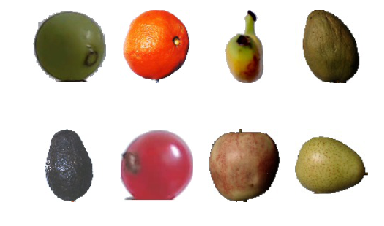

In [7]:
visualize_random_image(8)

### Batch layer (Not used)

In [0]:
# Input - X (batch_size,(height, width, channels))
# dtype - torch.Tensor
# (64,3,h,w)

# class BatchNormCustom(nn.Module):
    
#     def __init__(self, gamma = 1, beta = 0, eps = 1e-5):
#         super().__init__()
#         self.X = None
#         self.gamma = torch.FloatTensor(gamma)
#         self.beta = torch.FloatTensor(beta)
#         self.eps = torch.tensor(eps)
        
#     def forward(self,X):
#         self.X = X
#         m  = X.shape[0]
#         mu = torch.mul((1/m),torch.sum(X, 0))
#         var = torch.mul((1/m),torch.sum((X - mu) ** 2, 0))
#         X_norm = (X - mu)/torch.sqrt(var + self.eps)
#         return  self.gamma * X_norm + self.beta

#     def params(self):
#         return { 'gamma': self.gamma, 'beta': self.beta}

### Defining model, loss function, optimizer

In [0]:
# Flat input to use in Fully-Connected layer
class Flattener(nn.Module):  

    def forward(self,X):
        self.X_shape = X.shape
        return X.view(self.X_shape[0],-1)

    
model = nn.Sequential(nn.Conv2d(3,20,5, bias = False),
                      nn.BatchNorm2d(20),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(4),
                      nn.Conv2d(20,20,5, bias = False),
                      nn.BatchNorm2d(20),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(4),
                      Flattener(),
                      nn.Linear(20 * 5 *5, 96, bias = True)
                     )

device = torch.device("cuda:0")

model.to(device)
model.type(torch.cuda.FloatTensor)

if torch.cuda.device_count() > 1:
    print("GPU: ", torch.cuda.device_count())
    model = nn.DataParallel(model)


loss_f = nn.CrossEntropyLoss(reduction = "mean").type(torch.cuda.FloatTensor)
optim = torch.optim.Adam(model.parameters(),lr = 1e-3, weight_decay=1e-5)

### Compute accuracy for given model and data loader

In [0]:
def compute_accuracy(model, data_loader):
    model.eval()
    
    correct_prediction = 0
    total_samples = 0
    batch_size = data_loader.batch_size
    
    for x,y in data_loader:
        x_device = x.to(device)
        y_device = y.to(device)
        
        output = model(x_device)
        prediction = torch.argmax(output,1)
        correct_prediction += torch.sum(prediction == y_device)
        total_samples += batch_size
        
    return float(correct_prediction)/ total_samples

### Training function

In [0]:
def train(model, train_loader, validation_loader, loss, optimizer,num_epochs, verbose = False):
    train_loss_history, train_acc_history, val_acc_history = [], [], []
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)
    for epoch in range(num_epochs):
        model.train()
        
        scheduler.step()
        
        train_loss = 0
        correct_train_samples = 0.
        total_train_samples = len(train_loader.sampler.indices)
        for i_batch, (x,y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            output = model(x_gpu)
            prediction = torch.argmax(output,1)
            loss_value = loss(output,y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
                
            train_loss += loss_value
            correct_train_samples += torch.sum(prediction == y_gpu)
            torch.cuda.empty_cache()
            
        train_acc = float(correct_train_samples) / total_train_samples
        val_acc = compute_accuracy(model,validation_loader)
        
        train_loss_history.append(train_loss/ (i_batch+1))
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        
        torch.cuda.empty_cache()
        if verbose:
            print("Epoch : %d, Train loss - %f, train_acc - %f, val_acc - %f" % (epoch+1, train_loss, train_acc, val_acc))
    
    return train_loss_history, train_acc_history, val_acc_history
        

In [14]:
# train on toy data
train_loss_history, train_acc_history, val_acc_history = train(model, train_loader, val_loader, loss_f, optim, 10, verbose = True) 

Epoch : 1, Train loss - 562.384033, train_acc - 0.914554, val_acc - 0.996119
Epoch : 2, Train loss - 22.378996, train_acc - 0.998236, val_acc - 0.992953
Epoch : 3, Train loss - 20.479855, train_acc - 0.996422, val_acc - 0.998366
Epoch : 4, Train loss - 6.909287, train_acc - 0.999054, val_acc - 0.998877
Epoch : 5, Train loss - 1.048268, train_acc - 0.999974, val_acc - 0.998877
Epoch : 6, Train loss - 0.936995, train_acc - 0.999974, val_acc - 0.998877
Epoch : 7, Train loss - 0.747516, train_acc - 1.000000, val_acc - 0.998877
Epoch : 8, Train loss - 0.650267, train_acc - 1.000000, val_acc - 0.998877
Epoch : 9, Train loss - 0.548578, train_acc - 1.000000, val_acc - 0.998877
Epoch : 10, Train loss - 0.437078, train_acc - 1.000000, val_acc - 0.998877


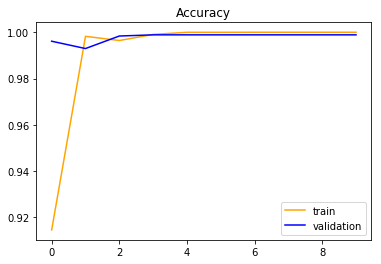

In [15]:
plt.plot(train_acc_history, color="orange")
plt.plot(val_acc_history, color = "blue")
plt.legend(("train", "validation"))
plt.title("Accuracy");

Text(0.5, 1.0, 'Training Loss history')

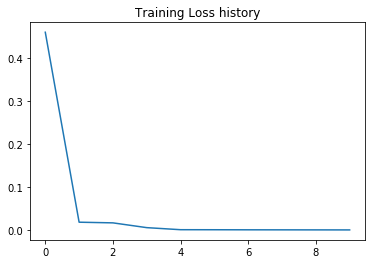

In [16]:
plt.plot(train_loss_history)
plt.title("Training Loss history")

### Grid Search

In [0]:
regularization = [1e-4, 1e-5] 
learning_rate = [1e-3, 1e-4]

In [0]:
def make_new_optim_model(reg, lr):
    model = nn.Sequential(nn.Conv2d(3,20,5, bias = False),
                              nn.BatchNorm2d(20),
                              nn.ReLU(inplace=True),
                              nn.MaxPool2d(4),
                              nn.Conv2d(20,10,5, bias = False),
                              nn.BatchNorm2d(10),
                              nn.ReLU(inplace=True),
                              nn.MaxPool2d(4),
                              Flattener(),
                              nn.Linear(10 * 5 *5, 96, bias = True)
                             )
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay= reg )
    
    model.to(device)
    model.type(torch.cuda.FloatTensor)

    return optimizer,model
 

In [20]:
best_model_dict = {
    "model" : None,
    "optim" : None,
    "val_history" : [],
    "lr" : None,
    "reg" : None
}

best_val_acc = 0.0

for reg in regularization:
    for lr in learning_rate:  
            optimizer, model = make_new_optim_model(reg, lr)
          
            loss_history, train_history, val_history = train(model,train_loader,val_loader,loss_f, optimizer, 5) 
            
            if (val_history != []) and (val_history[-1] > best_val_acc) :
                best_model_dict["model"] = model.state_dict()
                best_model_dict["optim"] = optimizer.state_dict()
                best_model_dict["val_history"] = val_history
                best_model_dict["lr"] = lr
                best_model_dict["reg"] = reg
                
                
                best_val_acc = val_history[-1]
            
            print("LR = {} ; L2 = {} ; val_acc: {} ".format(lr, reg, val_history[-1]))

LR =0.001 ; L2 =0.0001 ; val_acc :0.9987745098039216 
LR =0.0001 ; L2 =0.0001 ; val_acc :0.9859068627450981 
LR =0.001 ; L2 =1e-05 ; val_acc :0.998672385620915 
LR =0.0001 ; L2 =1e-05 ; val_acc :0.9888684640522876 


In [48]:
# continue to train best model

optim_c, model_c = make_new__optim_model(best_model_dict["reg"],best_model_dict["lr"])
model_c.load_state_dict(best_model_dict["model"])
optim_c.load_state_dict(best_model_dict["optim"])

loss_history, train_history, val_history = train(model_c,train_loader,val_loader,loss_f, optim_c, 10, verbose=True)

Epoch : 1, Train loss - 1.512053, train_acc - 0.999719, val_acc - 0.998877
Epoch : 2, Train loss - 1.446136, train_acc - 0.999796, val_acc - 0.998877
Epoch : 3, Train loss - 1.284688, train_acc - 0.999744, val_acc - 0.998877
Epoch : 4, Train loss - 0.766879, train_acc - 0.999974, val_acc - 0.998775
Epoch : 5, Train loss - 0.718398, train_acc - 0.999974, val_acc - 0.998775
Epoch : 6, Train loss - 0.684528, train_acc - 0.999974, val_acc - 0.998775
Epoch : 7, Train loss - 0.705090, train_acc - 0.999949, val_acc - 0.998877
Epoch : 8, Train loss - 0.769282, train_acc - 0.999923, val_acc - 0.998775
Epoch : 9, Train loss - 0.590193, train_acc - 1.000000, val_acc - 0.998775
Epoch : 10, Train loss - 0.728644, train_acc - 0.999949, val_acc - 0.998877


### Save model state into file

In [0]:
from google.colab import files
torch.save(model, "gs_best_model")

files.download("gs_best_model")

### Test best model

In [18]:
compute_accuracy(model,test_loader)

0.9877188715953308